### **Neural Style Transfer**

This is an implementation of NST based on Neural Style Transfer with Eager Execution, an online tutorial found at https://github.com/nikhilagrawal2000/Neural-Style-Transfer-with-Eager-Execution. The changes made to the code are as follows:

1. Replace the test data used with my own personal choices of Monet artworks and landscape images.
2. Tune the Adam Optimiser and content/style weights as desired, and as supported by my literature review.
3. Introduce the Learned Perceptual Image Patch Similarity (LPIPS) as a quantitative measure of the success of style transfer. Write additional code to ensure the tensor sizes are equivalent in order to compare the input and output images.


**Some quick notes for Google Colab:**

1. All cells can be run using Shift+Enter.
2. To upload images, go to "Files" on the far-left of the screen, then click the top-left icon to upload images.
3. To upload images to a particular directory, hover over the directory, click on the dots on the far-right, and click the upload button.

In [ ]:
# import all libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [ ]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

To perform an example style transfer (for the beach), save, download, and upload the following images and upload them to Google Colab:

Content path (beach): https://www.google.com/url?sa=i&url=https%3A%2F%2Ffineartamerica.com%2Ffeatured%2F1-beautiful-sunset-at-brighton-jetty-in-adelaide-south-australia-peter-mundy.html&psig=AOvVaw3Vrk8yHJA8gqj8ifrrt3ml&ust=1635140051153000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCJiZ3sSp4vMCFQAAAAAdAAAAABAD

**For the beach image, use the link to the picture at the bottom of the webpage, not the larger image.**

Style path (Monet): https://www.google.com/url?sa=i&url=https%3A%2F%2Fshop.ariustechnology.com%2Fblogs%2Fnews%2Ftop-5-most-expensive-claude-monet-paintings-ever-sold&psig=AOvVaw0EsCvROE8ar9sg0SbGRlpV&ust=1635140108264000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCNC_i96p4vMCFQAAAAAdAAAAABAD

*An important note - after running style transfer, if you decide to review the Colab notebook at a later date, the previous session will be deleted. Consequently, all images uploaded to session storage will be deleted. Another important note - to prevent any bugs during style transfer, pleae ensure that both the input images are .jpg files.*

In [ ]:
# Set up some global values here
content_path = 'input1.jpg'
style_path = 'monet1.jpg'

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [ ]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

In [ ]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [ ]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [ ]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [ ]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [ ]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

A noteworthy point to discuss here is how the Adam optimiser is tuned. The justification for the hyperparameters tuned is found in my literature review, but please see the table below for the original and updated parameters.

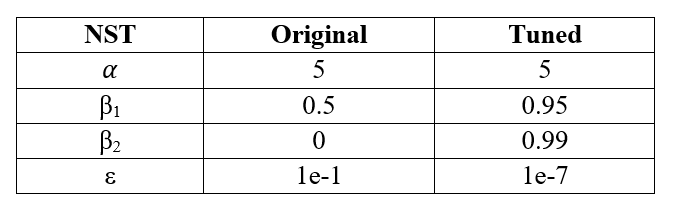


Two important points here:

1. Number of iterations was kept constant, can be increased but does not improve the results
2. A significant difference in the quality of the output is measured by the content and style weights
3. These were set to 1e-2 and 1e-5 respectively to yield optimal results

In [ ]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e-2, 
                       style_weight=1e-5): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer - SEE ADAM OPTIMIZER TABLE ABOVE TO SHOW TUNED/UNTUNED VALUES
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

In [ ]:
# Results are shown here
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

In [ ]:
Image.fromarray(best)

In [ ]:
# Show results - content and style image, as well as output displayed
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [ ]:
show_results(best, content_path, style_path)

The next two lines of code are for when you wish to repeat the experiment for another content and style pair. Once you have run style transfer for an example, feel free to upload two landscape and style images of your choosing to Colab, then replace the content and style paths with the file names of the inputs. Note that both images must be landscape, as style transfer for portrait images is not supported by the CNN architecture used in this NST implementation. 

For example for a content image (photograph) with file name flowers.jpg, and a style image (artwork) with file name vangogh1.jpg, the code would read as follows:

```
best_vangogh, best_loss = run_style_transfer('flowers.jpg', 'vangogh1.jpg')
show_results(best_vangogh, 'flowers.jpg', 'vangogh1.jpg')

```

Press Ctrl + / to uncomment the code below.

In [ ]:
# best_flowers, best_loss = run_style_transfer('input1.jpg', 'monet1.jpg')

In [ ]:
# show_results(best_beach, 'input1.jpg', 'monet1.jpg')

**Instructions to calculate perceptual distance given an input and output image**

1. Run the two lines of code below to create a Perceptual Distance directory.
2. Save the output image to desktop using the Snipping Tool, then upload them to the Perceptual Similarity directory. Give it a memorable name e.g. beach_output.jpg. Do not do this until you have run the two lines of code below.
2. Run the code to convert the images to the correct size, then save the image with a memorable name
3. Pass the images into the convert('RGB') function - use the images you have saved in Step 2
4. Pass the content path of each image into the line of code that calculates perceptual distance. If the process is repeated for another content/style pair, the paths of each image need to be updated

In [ ]:
# clone repo for perceptual distance
!git clone https://github.com/richzhang/PerceptualSimilarity

In [ ]:
# change directory
%cd PerceptualSimilarity/

Code below is based on this Stack Overflow article - ensures that images being used to calculate perceptual distance were of the same size. Note that the same code is used in Cycle-GAN.

https://stackoverflow.com/questions/47929557/tensorflow-cnn-training-images-are-all-different-sizes

In [ ]:
# Run this code (step 3) to convert the images to the correct size

from PIL import Image

basewidth = 50 # MNIST image width
img = Image.open('/content/PerceptualSimilarity/input1.jpg')
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((1000,800), Image.ANTIALIAS)

# Save image or feed directly to tensorflow, use a similar name as the saved image
# This new image will be used to calculate perceptual distance 
img.save('input1.jpg') 

In [ ]:
from PIL import Image

basewidth = 50 # MNIST image width
img = Image.open('/content/PerceptualSimilarity/beach_output.JPG')
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((1000,800), Image.ANTIALIAS)

# Save image or feed directly to tensorflow 
img.save('beach_output.JPG') 

In [ ]:
# need to convert these images to RGB to get the perceptual distance

In [ ]:
# step 4
test_image1 = Image.open('input1.jpg').convert('RGB')

In [ ]:
test_image2 = Image.open('beach_output.JPG').convert('RGB')

Example for step 5

`!python lpips_2imgs.py -p0 /path-to-output-image -p1 /path-to-style-image`

To get the path to an image, click on the image in the directory, then click on the dots on the far-right, then click copy path.

In [ ]:
# step 5
# get perceptual distance (p0 = original image, p1 = output) -> perceptual distance should be between 0 and 1
!python lpips_2imgs.py -p0 /content/PerceptualSimilarity/input1.jpg -p1 /content/PerceptualSimilarity/beach_output.JPG